# Naive Bayes Classifie
朴素贝叶斯分类器是与上一节介绍的线性模型非常相似的一种分类器，但它的训练速度往
往更快。这种高效率所付出的代价是，朴素贝叶斯模型的泛化能力要比线性分类器（如
LogisticRegression和LinearSVC）稍差。

**朴素贝叶斯 = 用概率做分类 + 忽略特征之间的关系 + 极其高效**  
它不是最准的，但往往是最快、最简单的选择！

它基于**贝叶斯定理**，并做了“**朴素假设**”：  
👉 所有特征之间**相互独立**（虽然现实中不成立，但效果依然很好！）

朴素贝叶斯模型如此高效的原因在于，它通过单独查看每个特征来学习参数，并从每
个特征中收集简单的类别统计数据。


## 为什么叫“朴素”？

因为它的核心假设是：

> **所有特征彼此独立**，即某个特征出现与否不影响其他特征。

比如判断一封邮件是不是垃圾邮件：

- 它认为：“出现‘免费’和‘中奖’这两个词是独立事件”
- 实际上它们可能相关，但模型忽略这一点 → 这就是“朴素”

尽管如此，这个假设让计算变得**极其简单快速**，所以它在很多场景下表现非常好！



## 分类


| 模型 | 学习什么？ | 举个例子 |
|------|------------|----------|
| `BernoulliNB` | 每个类别的每个特征中，**1 的个数** | 文本中某个词是否出现 |
| `MultinomialNB` | 每个类别的每个特征的**平均值** | 文本中某个词出现的**次数** |
| `GaussianNB` | 每个类别的每个特征的**均值和标准差** | 身高、体重等连续变量 |

> 💡 文中提到的 `BernoulliNB` 和 `MultinomialNB` 主要用于**文本分类**，比如垃圾邮件识别、情感分析等。


## BernoulliNB分类器

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [25]:
X = np.array([[0, 1, 0, 1], 
              [1, 0, 1, 1], 
              [0, 0, 0, 1], 
              [1, 0, 1, 0]]) 
y = np.array([0, 1, 0, 1])


这里我们有4个数据点，每个点有4个二分类特征。一共有两个类别：0和1。对于类别0
（第1、3个数据点），第一个特征有2个为零、0个不为零，第二个特征有1个为零、1个
不为零，以此类推。然后对类别1中的数据点计算相同的计数。计算每个类别中的非零元
素个数，大体上看起来像这样

In [26]:
counts = {} 
for label in np.unique(y): 
    # 对每个类别进行遍历 
    # 计算（求和）每个特征中1的个数 
    counts[label] = X[y == label].sum(axis=0) 
print("Feature counts:\n{}".format(counts))

Feature counts:
{np.int64(0): array([0, 1, 0, 2]), np.int64(1): array([2, 0, 2, 1])}


解释一下：

类别1（也就是第一行和第三行），是特征0

返回的[0,1,0,2] 就是两行相加的结果，同时也是“类别0中每个特征的1的个数”

所以特征0中有 0 个1，特征1中有 1 个1，特征2中有 0 个1，特征3中有 2 个1

就是这个意思，很聪明吧


# Decision Tree
决策树是广泛用于分类和回归任务的模型。本质上，它从一层层的if/else问题中进行学
习，并得出结论

这些问题类似于你在“20 Questions”游戏9中可能会问的问题。
如图所示

In [27]:
import sys
print("Using Python from:", sys.executable)

Using Python from: D:\Software\VR_ev\hands-on\Scripts\python.exe


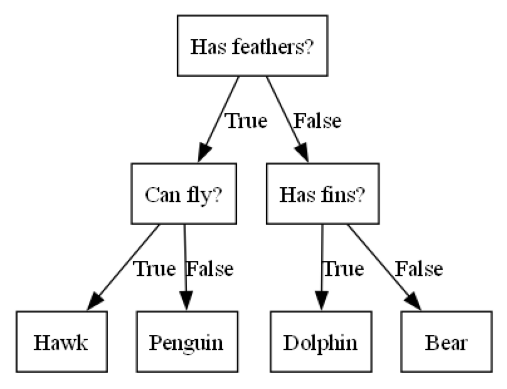

In [28]:
import mglearn
mglearn.plots.plot_animal_tree()

## 理解"纯"

书中说：“如果某个叶结点中所有数据的目标值都相同，那么这个叶结点就是**纯的（pure）**。”

✅ 举个例子：

- 如果某区域全是 ●（类别0），那就是纯的 → 预测结果就是类别0
- 如果某区域一半 ● 一半 △，那就是“不纯” → 预测时取多数（比如还是类别0）

所以，**决策树的目标是：  
👉 把数据一步步分割，直到每个区域尽可能“纯”。**

但问题来了：

> ❗ 如果一直分下去，直到每个点都单独在一个区域里，是不是就“最纯”了？

❌ 不是！那样的话，模型失去了泛化能力（generalization），只能记住训练数据。


## 控制决策树的复杂度
防止过拟合有两种常见的策略：一种是及早停止树的生长，也叫**预剪枝（pre-pruning）**；


另一种是先构造树，但随后删除或折叠信息量很少的结点，也叫**后剪枝（post-pruning**或
剪枝（pruning）。

预剪枝的限制条件可能包括限制树的最大深度、限制叶结点的最大数目，
或者规定一个结点中数据点的最小数目来防止继续划分。


| 方法 | 中文名 | 英文名 | 解释 |
|------|--------|--------|------|
| 1. 限制生长 | 预剪枝 | **pre-pruning** | 在构建树的过程中提前停止分裂（比如设置最大深度） |
| 2. 先建再删 | 后剪枝 | **post-pruning** | 先让树长满，然后再删掉不必要的分支 |


scikit-learn 的决策树在DecisionTreeRegressor 类和DecisionTreeClassifier 类中实现。
scikit-learn 只实现了预剪枝，没有实现后剪枝。


## 在乳腺癌数据集上看一下预剪枝
和前面一样，我们导入数据集并将
其分为训练集和测试集。然后利用默认设置来构建模型，默认将树完全展开（树不断分
支，直到所有叶结点都是纯的）。我们固定树的random_state，用于在内部解决平局问题：


In [8]:
from sklearn.tree import DecisionTreeClassifier 
cancer = load_breast_cancer() 
X_train, X_test, y_train, y_test = train_test_split( 
    cancer.data, cancer.target, stratify=cancer.target, random_state=42) 
tree = DecisionTreeClassifier(random_state=0) 
tree.fit(X_train, y_train) 
print("Accuracy on training set: {:.3f}".format(tree.score(X_train, y_train))) 
print("Accuracy on test set: {:.3f}".format(tree.score(X_test, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.937


不出所料，训练集上的精度是100%，这是因为叶结点都是纯的，树的深度很大，足以完
美地记住训练数据的所有标签。测试集精度比之前讲过的线性模型略低，线性模型的精度
约为95%。

**如果我们不限制决策树的深度，它的深度和复杂度都可以变得特别大。**

因此，**未剪枝的树容易过拟合，对新数据的泛化性能不佳。**

现在我们将预剪枝应用在决策树上，这可以在完美拟合训练数据之前阻止树的展开。

一种选择是在到达一定深度后停止树的展开。这里我
们设置max_depth=4，这意味着只可以连续问4个问题（参见图2-24和图2-26）。

**限制树的深度可以减少过拟合。这会降低训练集的精度，但可以提高测试集的精度：**

In [40]:
tree = DecisionTreeClassifier(max_depth=4, random_state=0) 
tree.fit(X_train, y_train) 
print("Accuracy on training set: {:.3f}".format(tree.score(X_train, y_train))) 
print("Accuracy on test set: {:.3f}".format(tree.score(X_test, y_test)))

Accuracy on training set: 0.975
Accuracy on test set: 1.000


## 分析决策树
我们可以利用tree模块的export_graphviz函数来将树可视化。

这个函数会生成一个.dot 格式的文件，这是一种用于保存图形的文本文件格式。我们设置为结点添加颜色
的选项，颜色表示每个结点中的多数类别，同时传入类别名称和特征名称，这样可以对
树正确标记：

In [48]:
from sklearn.tree import export_graphviz 
# 如果你想用全部 30 个特征
X = cancer.data  # 全部30个特征
y = cancer.target

tree.fit(X, y)   # 模型现在知道有30个特征

# 导出树
export_graphviz(tree,
                out_file="tree.dot",
                class_names=["malignant","benign"],
                feature_names=cancer.feature_names,  # 现在可以用了，因为确实是30个
                impurity=False,
                filled=True)

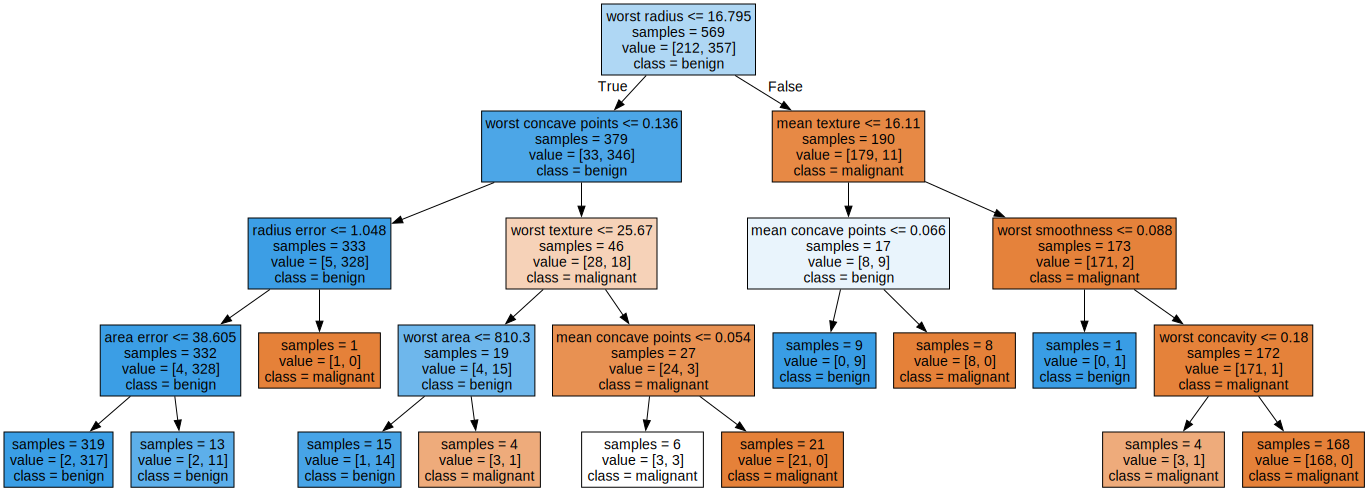

In [49]:
import graphviz 
with open("tree.dot") as f: 
    dot_graph = f.read() 
graphviz.Source(dot_graph)

## 树的特征重要性
查看整个树可能非常费劲，除此之外，我还可以利用一些有用的属性来总结树的工作原
理。

其中最常用的是**特征重要性（feature importance**它为每个特征对树的决策的重要性
进行排序。

对于每个特征来说，它都是一个介于0和1之间的数字，其中0表示“根本没
用到”，1表示“完美预测目标值”。特征重要性的求和始终为1：

In [51]:
print("Feature importances:\n{}".format(tree.feature_importances_))

Feature importances:
[0.         0.03310217 0.         0.         0.         0.
 0.         0.04307811 0.         0.         0.00776016 0.
 0.         0.00216938 0.         0.         0.         0.
 0.         0.         0.73782365 0.04092498 0.         0.01175894
 0.00783651 0.         0.00194727 0.11359883 0.         0.        ]


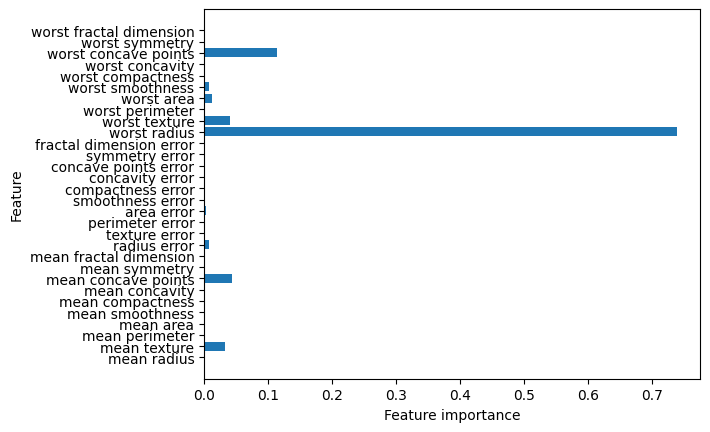

In [52]:
def plot_feature_importances_cancer(model): 
    n_features = cancer.data.shape[1] 
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), cancer.feature_names) 
    plt.xlabel("Feature importance") 
    plt.ylabel("Feature") 
plot_feature_importances_cancer(tree)

这里我们看到，顶部划分用到的特征（“worst radius”）是最重要的特征。这也证实了我们
在分析树时的观察结论，即第一层划分已经将两个类别区分得很好。

**但是，如果某个特征的feature_importance_很小，并不能说明这个特征没有提供任何信
息。这只能说明该特征没有被树选中，可能是因为另一个特征也包含了同样的信息。**

**与线性模型的系数不同，特征重要性始终为正数，也不能说明该特征对应哪个类别。**
  
特征重要性告诉我们“worst radius”（最大半径）特征很重要，但并没有告诉我们半径大表示
样本是良性还是恶性。事实上，在特征和类别之间可能没有这样简单的关系，你可以在下
面的例子中看出这一点

Feature importances: [0. 1.]


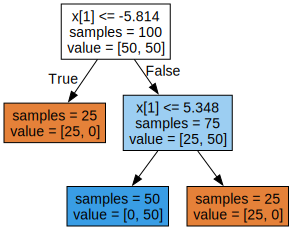

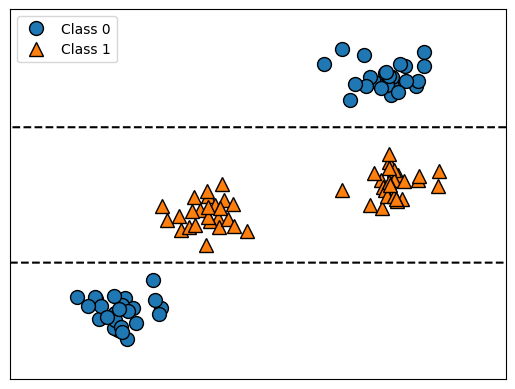

In [53]:
tree = mglearn.plots.plot_tree_not_monotone() 
display(tree)

该图显示的是有两个特征和两个类别的数据集。这里所有信息都包含在X[1]中，没有用到
X[0]。但X[1] 和输出类别之间并不是单调关系，即我们不能这么说：“较大的X[1]对应类
别0，较小的X[1]对应类别1”（反之亦然）。


虽然我们主要讨论的是用于分类的决策树，但对用于回归的决策树来说，所有内容都是
类似的，在DecisionTreeRegressor 中实现。

回归树的用法和分析与分类树非常类似。但
在将基于树的模型用于回归时，我们想要指出它的一个特殊性质。DecisionTreeRegressor
（以及其他所有基于树的回归模型）不能**外推（extrapolate**，也不能在训练数据范围之外
进行预测。

我们利用计算机内存（RAM）历史价格的数据集来更详细地研究这一点。图2-31给出了
这个数据集的图像，x轴为日期，y轴为那一年1兆字节（MB）RAM的价格：

Text(0, 0.5, 'Price in $/Mbyte')

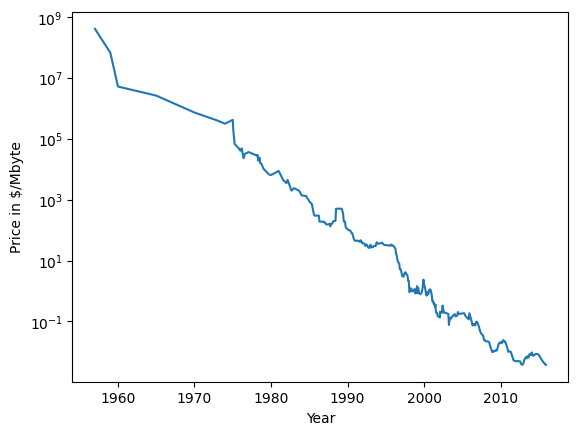

In [56]:
import os
ram_prices = pd.read_csv(os.path.join(mglearn.datasets.DATA_PATH, "ram_price.csv"))

plt.semilogy(ram_prices.date, ram_prices.price)
plt.xlabel("Year")
plt.ylabel("Price in $/Mbyte")

注意y轴的对数刻度。在用对数坐标绘图时，二者的线性关系看起来非常好，所以预测应
该相对比较容易，除了一些不平滑之处之外。


我们将利用2000年前的历史数据来预测2000年后的价格，只用日期作为特征。我们将
对比两个简单的模型：DecisionTreeRegressor 和LinearRegression。我们对价格取对数，
使得二者关系的线性相对更好。

这对DecisionTreeRegressor不会产生什么影响，但对
LinearRegression 的影响却很大（我们将在第4章中进一步讨论）。训练模型并做出预测之
后，我们应用指数映射来做对数变换的逆运算。为了便于可视化，我们这里对整个数据集
进行预测，但如果是为了定量评估，我们将只考虑测试数据集：

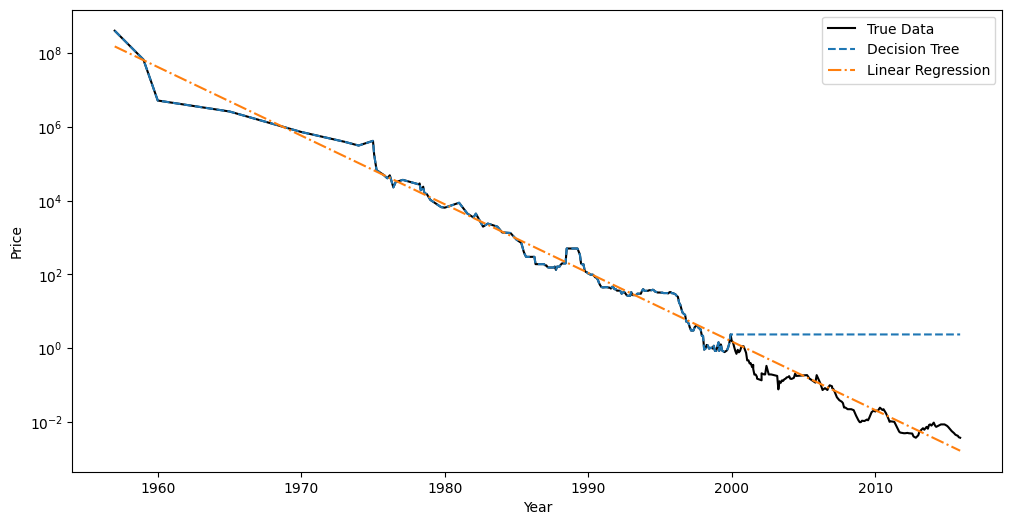

In [63]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt

# 假设 ram_prices 是一个 DataFrame，包含 'date' 和 'price' 两列

# 分割训练集和测试集
data_train = ram_prices[ram_prices.date < 2000]
data_test = ram_prices[ram_prices.date >= 2000]

# 准备训练数据：特征 X 是 date，目标 y 是 log(price)
X_train = data_train.date.values.reshape(-1, 1)      # ✅ 改这里！
y_train = np.log(data_train.price)

# 训练模型
tree = DecisionTreeRegressor().fit(X_train, y_train)
linear_reg = LinearRegression().fit(X_train, y_train)

# 对所有年份做预测（从最早到最晚）
X_all = ram_prices.date.values.reshape(-1, 1)         # ✅ 也改这里！

pred_tree = tree.predict(X_all)
pred_lr = linear_reg.predict(X_all)

# 逆变换：把 log(price) 变回原始价格
price_tree = np.exp(pred_tree)
price_lr = np.exp(pred_lr)

plt.figure(figsize=(12, 6))
plt.semilogy(ram_prices.date, ram_prices.price, label="True Data", color="black")
plt.semilogy(ram_prices.date, price_tree, label="Decision Tree", linestyle='--')
plt.semilogy(ram_prices.date, price_lr, label="Linear Regression", linestyle='-.')
plt.xlabel("Year")
plt.ylabel("Price")
plt.legend()
plt.show()

两个模型之间的差异非常明显。

线性模型用一条直线对数据做近似，这是我们所知道的。
这条线对测试数据（2000年后的价格）给出了相当好的预测，不过忽略了训练数据和测试
数据中一些更细微的变化。

与之相反，树模型完美预测了训练数据。由于我们没有限制树
的复杂度，因此它记住了整个数据集。但是，一旦输入超出了模型训练数据的范围，模型
就只能持续预测最后一个已知数据点。

**树不能在训练数据的范围之外生成“新的”响应。所有基于树的模型都有这个缺点**

## 优点、缺点和参数
如前所述，控制决策树模型复杂度的参数是预剪枝参数，它在树完全展开之前停止树的构
造。

通常来说，选择一种预剪枝策略（设置max_depth、max_leaf_nodes或min_samples_
 leaf）足以防止过拟合。

与前面讨论过的许多算法相比，决策树有两个优点：

一是**得到的模型很容易可视化**，非
专家也很容易理解（至少对于较小的树而言）；

二是**算法完全不受数据缩放的影响**。由于
每个特征被单独处理，而且数据的划分也不依赖于缩放，因此决策树算法不需要特征预处
理，比如归一化或标准化。**特别是特征的尺度完全不一样时或者二元特征和连续特征同时
存在时，决策树的效果很好**

决策树的主要缺点在于，**即使做了预剪枝，它也经常会过拟合，泛化性能很差**。因此，在
大多数应用中，往往使用下面介绍的集成方法来替代单棵决策树。


# Ensemble of Decision Trees
是一种通过组合多个决策树来提升模型性能的机器学习方法。

**集成（ensemble**是合并多个机器学习模型来构建更强大模型的方法。

在机器学习文献
中有许多模型都属于这一类，但已证明有两种集成模型对大量分类和回归的数据集都是
有效的，二者都以决策树为基础，分别是随机森林（random forest）和梯度提升决策树
（gradient boosted decision tree）



## random forest
随机森林 = 很多棵“有点不一样”的决策树 + 投票/平均 

用来解决单个决策树容易“过拟合”（即只记住了训练数据的细节，对新数据表现差）的问题。

### 随机森林怎么解决？
通过两个关键的“随机化”手段，让每棵树都不完全一样，从而降低整体模型的过拟合风险：

1.对样本进行**随机采样Bootstrap**

2.对特征进行随机选择

然后用所有树的结果做平均（回归）或投票（分类），得到最终预测。


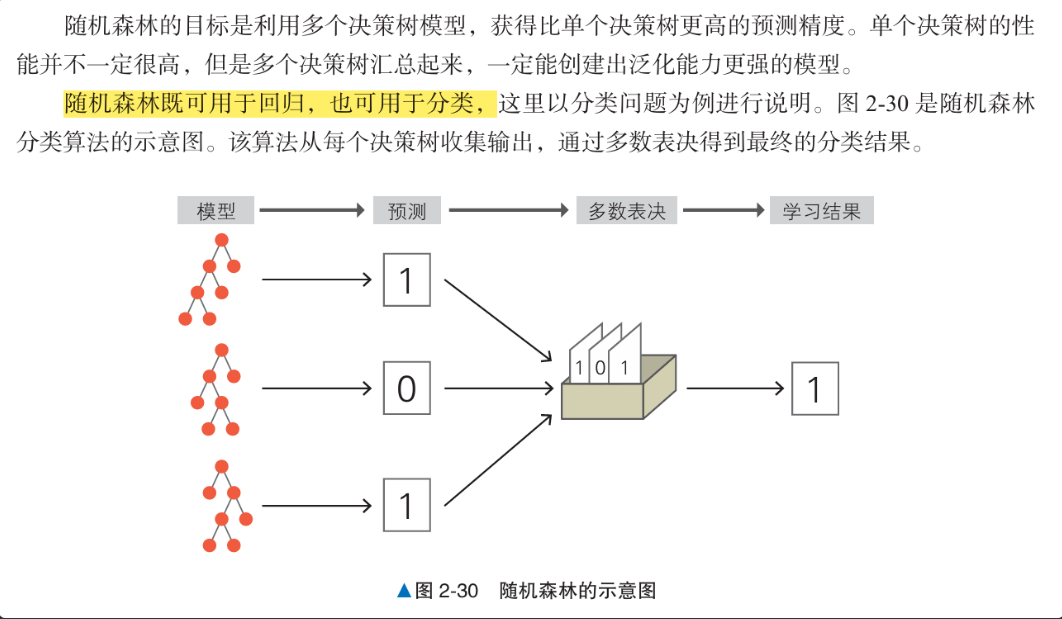

### 自助采样（Bootstrap Sampling）


从原始数据中**有放回地随机抽取**相同数量的样本，组成一个新的训练集。

> ✅ “有放回”意思是：抽出来的样本可以重复出现，有些样本可能被多次选中，有些则一次都没被选中。

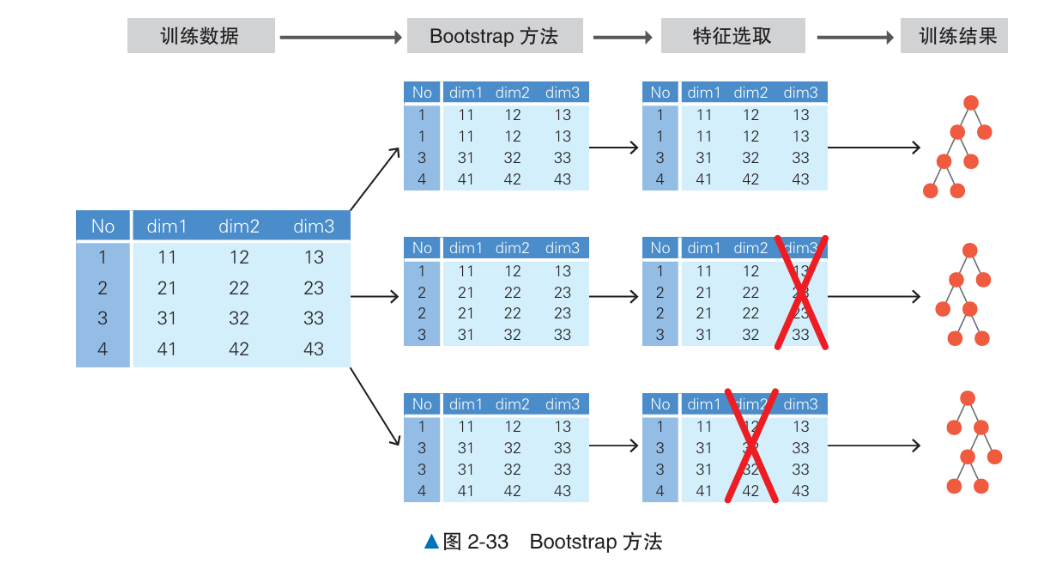

### 📌 举个例子：

假设你的原始数据是 4 个样本：`['a', 'b', 'c', 'd']`

我们进行一次自助采样（抽 4 次，每次从这 4 个里随机选一个，可重复）：

- 可能结果1：`['b', 'd', 'd', 'c']` → b 和 d 出现了两次，a 没出现
- 可能结果2：`['d', 'a', 'd', 'a']` → a 和 d 各出现两次，b、c 没出现

👉 这样每个新数据集都略有不同，有的样本多，有的少，甚至缺失。

这个过程叫 **bootstrap sampling**，它是随机森林的第一层“随机”。

### 第二步：用这些数据集分别训练决策树

现在你有了很多个不同的“小数据集”，每个都用来训练一棵决策树。

但注意：**不能直接照搬原来的方法去建树！**

因为如果每棵树都看全量特征，那它们可能长得太像，失去多样性。

所以要加第二层随机性！

---

### 第三步：在建树时，每次只随机选一部分特征来分裂

在构建每一棵树时，**不是考虑所有特征**，而是先从所有特征中**随机选出一部分子集**，再在这部分特征中找最好的划分方式。

比如你有 10 个特征：`[A, B, C, ..., J]`

在某个节点上，系统会：
1. 随机挑选出其中的 3 个特征（比如 A、F、H）；
2. 在这三个里面找出哪个特征能把数据分得最好；
3. 用这个最优特征来划分。

这个过程叫 **随机特征选择**，由参数 `max_features` 控制。

### 为什么这样能防过拟合？

| 问题 | 解决方式 |
|------|---------|
| 单棵树记住噪音？ | 每棵树只看部分数据，避免记住个别错误 |
| 单棵树依赖某个特征？ | 每次只用部分特征，防止过度依赖某个变量 |
| 单棵树太复杂？ | 多棵树平均，降低整体波动 |

👉 所以，即使每棵树都“有点傻”，但**集体决策很聪明**！

### 参数解释

这是影响随机森林性能的重要参数！

| `max_features` 的值 | 含义 | 影响 |
|---------------------|------|------|
| `n_features`（全部特征） | 每次都看所有特征 | 树之间差异小，容易相似，可能过拟合 |
| `sqrt(n_features)` | 比如 10 个特征就选 √10 ≈ 3 个 | 是默认值，平衡多样性和效果 |
| `log2(n_features)` | 对数级别，适合高维数据 | 更加随机，树差异大 |
| `1` | 每次只能选一个特征 | 非常随机，树很不一样，但可能欠拟合 |

💡 **总结：**
- `max_features` 越小 → 每棵树越“随机” → 树之间差异越大 → 整体更稳定；
- 但太小会导致每棵树都不够强，预测不准；
- 所以需要调参找到最佳平衡点。


想要利用随机森林进行预测，算法首先对森林中的每棵树进行预测。

对于回归问题，我们可以对这些结果取平均值作为最终预测。

对于分类问题，则用到了***软投票***soft voting
策略。也就是说，每个算法做出“软”预测，给出每个可能的输出标签的概率。对所有树
的预测概率取平均值，然后将概率最大的类别作为预测结果。

## 分析随机森林（two—moons）


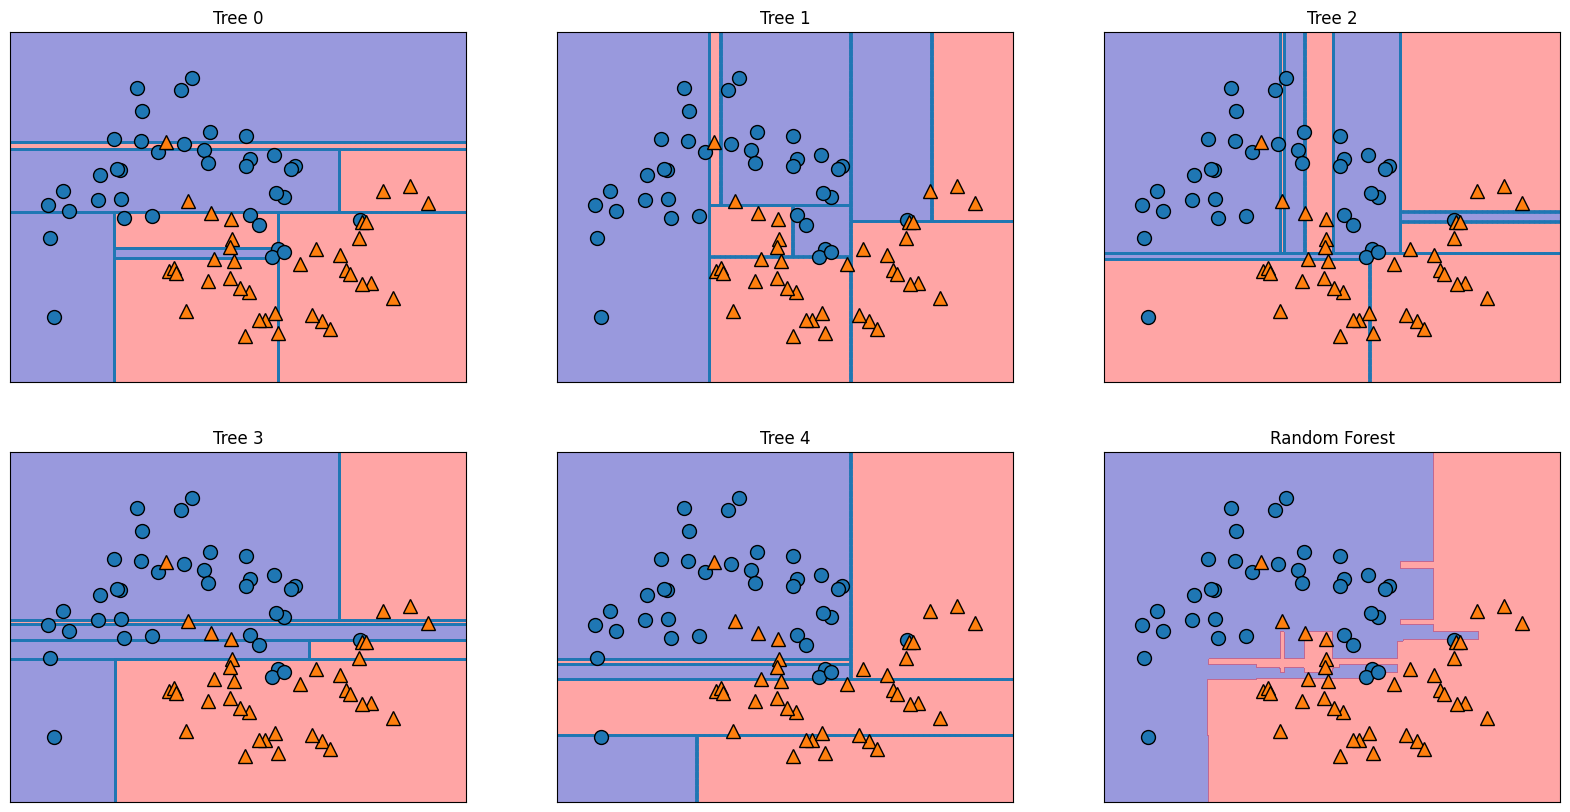

In [65]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10)) 
for i, (ax, tree) in enumerate(zip(axes.ravel(), forest.estimators_)): 
    ax.set_title("Tree {}".format(i)) 
    mglearn.plots.plot_tree_partition(X_train, y_train, tree, ax=ax) 
mglearn.plots.plot_2d_separator(forest, X_train, fill=True, ax=axes[-1, -1], 
                                alpha=.4) 
axes[-1, -1].set_title("Random Forest") 
mglearn.discrete_scatter(X_train[:, 0], X_train[:, 1], y_train)

你可以清楚地看到，这5棵树学到的决策边界大不相同。每棵树都犯了一些错误，因为这
里画出的一些训练点实际上并没有包含在这些树的训练集中，原因在于自助采样。

**随机森林比单独每一棵树的过拟合都要小，给出的决策边界也更符合直觉**

在任何实际应用中，我们会用到更多棵树（通常是几百或上千），从而得到更平滑的边界。

### 分析随机森林（breast cancer）
再举一个例子，我们将包含100棵树的随机森林应用在乳腺癌数据集上：

In [66]:
X_train, X_test, y_train, y_test = train_test_split( 
    cancer.data, cancer.target, random_state=0) 
forest = RandomForestClassifier(n_estimators=100, random_state=0) 
forest.fit(X_train, y_train) 
print("Accuracy on training set: {:.3f}".format(forest.score(X_train, y_train))) 
print("Accuracy on test set: {:.3f}".format(forest.score(X_test, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.972


在没有调节任何参数的情况下，随机森林的精度为97%，比线性模型或单棵决策树都要
好。我们可以调节max_features参数，或者像单棵决策树那样进行预剪枝。但是，随机森
林的默认参数通常就已经可以给出很好的结果。

与决策树类似，随机森林也可以给出特征重要性，计算方法是将森林中所有树的特征重要
性求和并取平均。

**一般来说，随机森林给出的特征重要性要比单棵树给出的更为可靠**

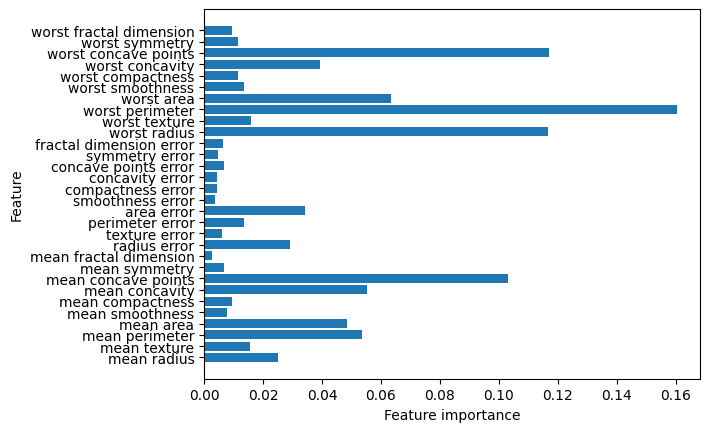

In [68]:
plot_feature_importances_cancer(forest)

如你所见，**与单棵树相比，随机森林中有更多特征的重要性不为零。**

与单棵决策树类似，
随机森林也给了“worst radius”（最大半径）特征很大的重要性，但从总体来看，它实际
上却选择“worst perimeter”（最大周长）作为信息量最大的特征。

由于构造随机森林过程
中的随机性，算法需要考虑多种可能的解释，结果就是随机森林比单棵树更能从总体把握
数据的特征

### 优点
1. 强大且效果好
   用于回归和分类，是目前最广泛使用的机器学习方法之一。
   通常不需要反复调参就能得到很好的结果。
   
2. 无需数据预处理
   不需要对数据进行缩放（如归一化或标准化），可以直接使用原始数据。

3. 继承了决策树的优点
    比如能处理混合类型特征（数值+类别）、不受特征尺度影响等。

4. 抗过拟合能力强
    多棵树投票/平均，降低了单棵决策树容易过拟合的问题。

5. 支持并行计算
    每棵树独立训练，可以在多核 CPU 上并行运行，速度提升明显。
    使用 n_jobs 参数可控制使用多少个核心（设为 -1 可用所有核心）。

6. 鲁棒性强
    对噪声和异常值不敏感，模型稳定性高。

### 缺点
1. 可解释性差：虽然直观，但是森林太大了
    如果你需要向非专家展示“为什么预测这个结果”，可能更适合用单棵决策树。

2. 训练和预测时间长

3. 内存占用高

4. 不适合高位稀疏数据（文本）

 
5. 结果具有随机性
    因为训练过程中有随机采样和随机特征选择，所以每次运行可能得到不同结果。
    若需结果可重现，必须设置 random_state 参数。


### 重要参数说明

| 参数 | 作用 | 调参建议 |
|------|------|-----------|
| `n_estimators` | 决定构建多少棵树 | 越多越好，但收益递减。经验法则是：在时间和内存允许下尽量多（如 100~500）。 |
| `max_features` | 每次分裂时考虑的特征数量 | 控制随机性。<br>• 分类任务默认：`sqrt(n_features)`<br>• 回归任务默认：`n_features`<br>较小值有助于降低过拟合。 |
| `max_depth` | 树的最大深度 | 可防止单棵树太深导致过拟合，但不是必须调的参数。 |
| `min_samples_split` / `min_samples_leaf` | 控制节点划分的最小样本数 | 防止过度细分，避免过拟合。 |
| `random_state` | 设置随机种子 | 保证结果可重现，非常重要！ |
| `n_jobs` | 使用的CPU核心数 | 设为 `-1` 表示使用所有核心，加速训练；不能超过实际核心数。 |

---

***总结一句话***

> **随机森林是一种强大、稳定、几乎“开箱即用”的模型，适合大多数结构化数据任务，但牺牲了可解释性和速度，不适合高维稀疏数据或实时场景。**

## gradient boosted decision tree

**梯度提升回归树（梯度提升机)**

### 定义

虽然名字中含有“回归”，但这个模型既可以用于回归也可以用于分类。与随机森林方法不
同，梯度提升采用连续的方式构造树，每棵树都试图纠正前一棵树的错误。

默认情况下，
梯度提升回归树中**没有随机化**，而是用到了**强预剪枝**。梯度提升树通常使用深度很小（1   
到5之间）的树，这样模型占用的内存更少，预测速度也更快。

梯度提升背后的主要思想是合并许多简单的模型（在这个语境中叫作**弱学习器**），比如深
度较小的树。每棵树只能对部分数据做出好的预测，因此，添加的树越来越多，可以不断
迭代提高性能。

梯度提升树经常是机器学习竞赛的优胜者，并且广泛应用于业界。
**与随机森林相比，它通常对参数设置更为敏感，但如果参数设置正确的话，模型精度更高**
  
除了预剪枝与集成中树的数量之外，梯度提升的另一个重要参数是**learning_rate**（学习
率），用于控制每棵树纠正前一棵树的错误的强度。

**较高的学习率意味着每棵树都可以做
出较强的修正，这样模型更为复杂。**
  
通过增大n_estimators来向集成中添加更多树，也可
以增加模型复杂度，因为模型有更多机会纠正训练集上的错误。

#### 拟合乳腺癌
下面是在乳腺癌数据集上应用GradientBoostingClassifier的示例。默认使用100棵树，
最大深度是3，学习率为0.1：

In [70]:
from sklearn.ensemble import GradientBoostingClassifier 
X_train, X_test, y_train, y_test = train_test_split( 
    cancer.data, cancer.target, random_state=0) 
gbrt = GradientBoostingClassifier(random_state=0) 
gbrt.fit(X_train, y_train) 
print("Accuracy on training set: {:.3f}".format(gbrt.score(X_train, y_train))) 
print("Accuracy on test set: {:.3f}".format(gbrt.score(X_test, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.965


### 降低过拟合的两种方法
由于训练集精度达到100%，所以很可能存在过拟合。为了降低过拟合，我们可以限制最
大深度来加强预剪枝，也可以降低学习率：

In [72]:
# 强预剪枝
gbrt = GradientBoostingClassifier(random_state=0, max_depth=1) 
gbrt.fit(X_train, y_train) 
print("Accuracy on training set: {:.3f}".format(gbrt.score(X_train, y_train))) 
print("Accuracy on test set: {:.3f}".format(gbrt.score(X_test, y_test)))

Accuracy on training set: 0.991
Accuracy on test set: 0.972


In [73]:
# 降低learning rate
gbrt = GradientBoostingClassifier(random_state=0, learning_rate=0.01) 
gbrt.fit(X_train, y_train)
print("Accuracy on training set: {:.3f}".format(gbrt.score(X_train, y_train))) 
print("Accuracy on test set: {:.3f}".format(gbrt.score(X_test, y_test)))

Accuracy on training set: 0.988
Accuracy on test set: 0.958


降低模型复杂度的两种方法都降低了训练集精度，这和预期相同。在这个例子中，减小树
的最大深度显著提升了模型性能，而降低学习率仅稍稍提高了泛化性能。

我解释一下：

**方法一：限制树的最大深度（强预剪枝）为什么有效**

每棵决策树就像一个“小专家”。如果允许它长得很深（比如10层），它就会记住很多细节，甚至包括噪音和巧合。

比如：“所有穿红衣服的人没生病” → 这可能是偶然，但深树会当成规律！ 

所以，我们设置 max_depth=1，意思是：

“每棵树只能问一个问题就做决定。” 

树变浅了 → 复杂度下降 → 不容易记住噪声；

虽然训练集精度从 100% 降到 99.1%，但测试集从 96.5% 提升到 97.2%；

牺牲一点点训练效果，换来更大的泛化能力！

**泛化能力强” = 能举一反三、应对新情况** 

✅ 结论：**限制最大深度 = 强制模型简单化，防止“死记硬背”**

降低学习率是“温和调节”，让模型学得更稳，但不会改变它的本质复杂性 → 只能轻微改善泛化。 



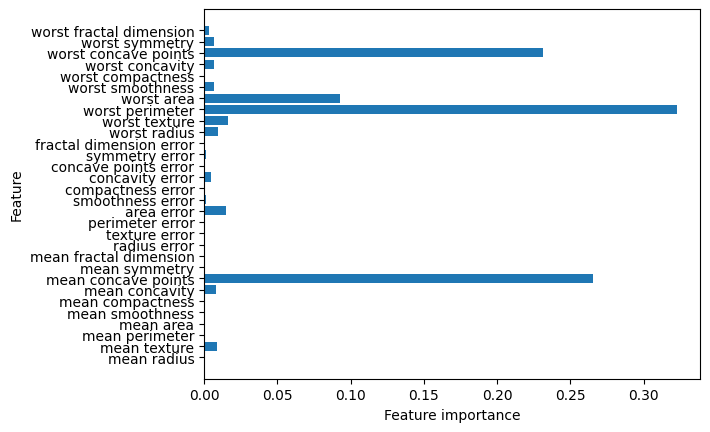

In [74]:
gbrt = GradientBoostingClassifier(random_state=0, max_depth=1) 
gbrt.fit(X_train, y_train) 
plot_feature_importances_cancer(gbrt)

可以看到，梯度提升树的特征重要性与随机森林的特征重要性有些类似，不过梯度提升完
全忽略了某些特征。

由于梯度提升和随机森林两种方法在类似的数据上表现得都很好，因此一种常用的方法就
是**先尝试随机森林**，它的*鲁棒性*很好。

如果随机森林效果很好，但预测时间太长，或者机
器学习模型精度小数点后第二位的提高也很重要，那么切换成梯度提升通常会有用

**鲁棒性是什么**
鲁棒性（Robustness）= 抗干扰能力强，不容易出错 

随机森林很鲁棒：

数据有少量噪声？没关系；
特征有点乱？也没关系；
即使参数没调好，也能跑出不错的结果。

梯度提升稍弱一点：
它对数据质量、参数设置更敏感；
如果训练不好，容易过拟合或崩溃。

📌 所以：新手建议先用随机森林，因为它“傻瓜式友好”！

### 优缺点
**优点**
1. **非常强大且常用**
   - 是监督学习中最强大、最常用的模型之一；
   - 在很多任务中表现优异，尤其适合结构化数据。

2. **不需要数据预处理**
   - 不需要对特征进行缩放（如归一化或标准化）；
   - 可以同时处理二元特征（如性别）和连续特征（如年龄），非常灵活。

3. **适用于多种场景**
   - 能用于分类和回归问题；
   - 对噪声和异常值有一定鲁棒性。


**缺点**
1. **需要仔细调参**
   - 模型性能高度依赖参数设置；
   - 如果参数没调好，容易过拟合或欠拟合。

2. **训练时间较长**
   - 因为是“串行”训练（每棵树都依赖前一棵），所以比随机森林慢；
   - 特别是在大数据集上，训练耗时明显。

3. **不适用于高维稀疏数据**
   - 比如文本数据（词频向量）、推荐系统中的用户-物品矩阵；
   - 这类数据更适合线性模型或深度学习模型。

4. **可解释性差**
   - 虽然每棵树可以可视化，但整体是由多棵“纠正错误”的树叠加而成，难以直观理解。

### 重要参数详解

| `n_estimators` | 决定构建多少棵树 |  
- 值越大，模型越复杂，可能更准确；  
- 但也会导致过拟合和训练变慢；  
- 通常先根据时间和内存选择一个合理的数量（如 100~500），再配合 `learning_rate` 调优。  

| `learning_rate` | 控制每棵树对前一棵树错误的“纠正力度” |  
- 值越小（如 0.01~0.1），每棵树只做微小修正，训练更稳定，但需要更多树才能达到效果；  
- 值越大，收敛快，但容易过拟合；  
- 通常与 `n_estimators` 配合使用：低学习率 + 多棵树 = 更好的泛化能力。  

| `max_depth` 或 `max_leaf_nodes` | 控制每棵树的最大深度/叶子节点数 |  
- 用于防止单棵树太复杂，降低过拟合风险；  
- 一般设置得较小，**不超过 5**；  
- 设置得太深会导致模型记住训练数据细节，失去泛化能力。  
